<a href="https://colab.research.google.com/github/cesong2/Display-Sensor/blob/Chan/teamproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
#Load the data
telemetry_df = pd.read_csv("/content/PdM_telemetry.csv")
errors_df = pd.read_csv("/content/PdM_errors.csv")
maint_df = pd.read_csv("/content/PdM_maint.csv")
failures_df = pd.read_csv("/content/PdM_failures.csv")
machines_df = pd.read_csv("/content/PdM_machines.csv")
machines_age = pd.DataFrame(machines_df[['machineID','age']]).set_index('machineID')
machines_errors = pd.DataFrame(errors_df.groupby('machineID')['errorID'].count())
machines_maint = pd.DataFrame(maint_df.groupby('machineID')['comp'].count())
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())

In [ ]:
# 추출한 데이터 합치기
df_machines = pd.concat([machines_age, machines_errors, machines_maint, machines_failures], axis=1)
df_machines.rename(columns={'errorID':'error', 'comp':'replace'},inplace=True)
df_machines

In [3]:
# 상관관계 찾기 (피어슨 상관계수 사용)
df_machines.corr(method = "pearson")

,age,error,replace,failure
age,1.000000,0.106931,0.075445,0.476459
error,0.106931,1.000000,-0.026558,0.483735
replace,0.075445,-0.026558,1.000000,-0.030258
failure,0.476459,0.483735,-0.030258,1.000000


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49832 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_

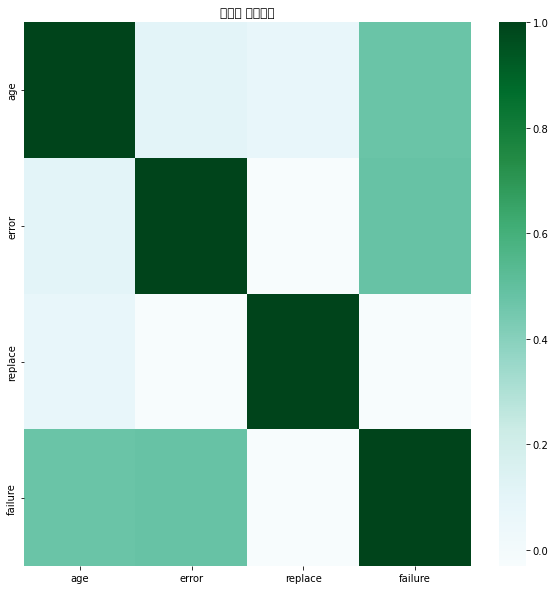

In [4]:
# 히트맵 시각화
matplotlib.rcParams['font.family'] = "NaNumGothic"  #나눔고딕체 사용
colormap = plt.cm.BuGn  #색설정 : BlueGreen
plt.figure(figsize = (10,10))
plt.title("피어슨 상관계수")
sns.heatmap(df_machines.astype(float).corr(), cmap=colormap)

In [5]:
#기계별 고장 데이터
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


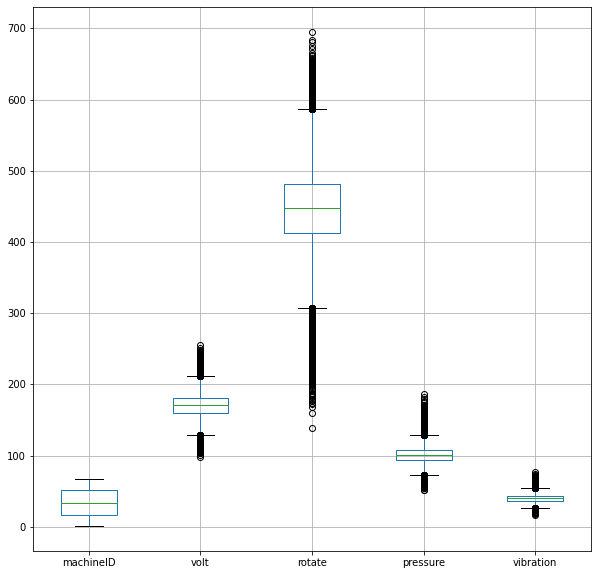

In [6]:
# 각 요인별 이상치 찾기
telemetry_df.boxplot(figsize=(10,10))
plt.show()

In [47]:
# 각 요인별 이상치 데이터 추출
def outlier(df, column):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (IQR * 1.5)
    maximum = Q3 + (IQR * 1.5)
    ###여기서부터 ㄴㄴ
    return pd.DataFrame(df['machineID'], df[[(df[column] > maximum) or (df[column] < minimum)]])

volt_outlier = outlier(telemetry_df, 'volt')
rotate_outlier = outlier(telemetry_df, 'rotate')
pressure_outlier = outlier(telemetry_df, 'pressure')
vibration_outlier = outlier(telemetry_df, 'vibration')

ValueError: ignored

In [86]:
Q1 = np.quantile(telemetry_df["volt"], 0.25)
Q3 = np.quantile(telemetry_df["volt"], 0.75)
IQR = Q3 - Q1
minimum = Q1 - (IQR * 1.5)
maximum = Q3 + (IQR * 1.5)
minimum

129.2802607757475

In [76]:
maximum,min
len(telemetry_df['volt'])

584955

In [84]:
minimum,max

(191.35778372711852, 160.319022251433)

In [87]:
im = []
nm = []
for i in range(len(telemetry_df['volt'])):
  if telemetry_df['volt'][i]>=maximum or telemetry_df['volt'][i]<=minimum:
    im.append(telemetry_df['volt'][i])
    nm.append(telemetry_df['machineID'][i])

In [88]:
len(im),

4986

In [ ]:
#컴포넌트 교체주기 확인

In [257]:
#maint 데이터파일 0과 1로 정리해주기
import numpy as np
comp_rep = pd.get_dummies(maint_df.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID','comp1', 'comp2', 'comp3', 'comp4']
comp_rep = telemetry_df[['datetime', 'machineID']].merge(comp_rep,on=['datetime','machineID'],how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

In [258]:
#maint 데이터파일 시간대별로 채우기
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(),
                 comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

##몇번 교체되었는지 component별 확인

In [266]:
#컴포넌트별 모든 시간대 정리
comp1_t = pd.DataFrame(comp_rep, columns = ['datetime','machineID','comp1'])
comp2_t = pd.DataFrame(comp_rep, columns = ['datetime','machineID','comp2'])
comp3_t = pd.DataFrame(comp_rep, columns = ['datetime','machineID','comp3'])
comp4_t = pd.DataFrame(comp_rep, columns = ['datetime','machineID','comp4'])

In [267]:
#컴포넌트 시간대별 중복 데이터 정리 (586799데이터 中)
comp1_rep = comp1_t.drop_duplicates(['comp1']) #303데이터열
comp2_rep = comp2_t.drop_duplicates(['comp2']) #317데이터열
comp3_rep = comp3_t.drop_duplicates(['comp3']) #311데이터열
comp4_rep = comp4_t.drop_duplicates(['comp4']) #314데이터열

In [139]:
print(f'comp1은 {len(comp1_rep)}번 교체, comp2은 {len(comp2_rep)}번 교체, comp3은 {len(comp3_rep)}번 교체, comp4은 {len(comp4_rep)}번 교체,')

comp1은 303번 교체, comp2은 317번 교체, comp3은 311번 교체, comp4은 314번 교체,


In [268]:
comp1 = comp1_rep.set_index('datetime').reset_index()
comp2 = comp2_rep.set_index('datetime').reset_index()
comp3 = comp3_rep.set_index('datetime').reset_index()
comp4 = comp4_rep.set_index('datetime').reset_index()

In [ ]:
#결측치 제거 전 (Nan값제거)
comp1
comp2
comp3
comp4
#결측치 제거 후 (Nan값제거)
comp1_n = comp1.dropna(axis=0) #결측치 1개 삭제
comp2_n = comp2.dropna(axis=0) #결측치 0개 삭제
comp3_n = comp3.dropna(axis=0) #결측치 1개 삭제
comp4_n = comp4.dropna(axis=0) #결측치 1개 삭제
#순서 재배치
comp1_n = comp1_n.set_index('datetime').reset_index()
comp2_n = comp2_n.set_index('datetime').reset_index()
comp3_n = comp3_n.set_index('datetime').reset_index()
comp4_n = comp4_n.set_index('datetime').reset_index()

In [ ]:
#나중에 def 로 수정해주기

In [335]:
#datetime 을 이용한 교체주기 확인
comp1_re = []
n = 1
for i in range(len(comp1_n)-1):
  if n != range(len(comp1_n)):
    str_datetime1 = comp1_n["comp1"][n]
    str_datetime2 = comp1_n["comp1"][i]
    currdate1 = datetime.strptime(str_datetime1, '%Y-%m-%d %H:%M:%S')
    currdate2 = datetime.strptime(str_datetime2, '%Y-%m-%d %H:%M:%S')
    new = currdate1- currdate2
    comp1_re.append(new.days)
    n += 1
  else:
    break
comp2_re = []
n1 = 1
for i in range(len(comp2_n)-1):
  if n1 != range(len(comp2_n)):
    str_datetime1 = comp2_n["comp2"][n1]
    str_datetime2 = comp2_n["comp2"][i]
    currdate1 = datetime.strptime(str_datetime1, '%Y-%m-%d %H:%M:%S')
    currdate2 = datetime.strptime(str_datetime2, '%Y-%m-%d %H:%M:%S')
    new = currdate1- currdate2
    comp2_re.append(new.days)
    n1 += 1
  else:
    break
comp3_re = []
n2 = 1
for i in range(len(comp3_n)-1):
  if n2 != range(len(comp3_n)):
    str_datetime1 = comp3_n["comp3"][n2]
    str_datetime2 = comp3_n["comp3"][i]
    currdate1 = datetime.strptime(str_datetime1, '%Y-%m-%d %H:%M:%S')
    currdate2 = datetime.strptime(str_datetime2, '%Y-%m-%d %H:%M:%S')
    new = currdate1- currdate2
    comp3_re.append(new.days)
    n2 += 1
  else:
    break
comp4_re = []
n3 = 1
for i in range(len(comp4_n)-1):
  if n3 != range(len(comp4_n)):
    str_datetime1 = comp4_n["comp4"][n3]
    str_datetime2 = comp4_n["comp4"][i]
    currdate1 = datetime.strptime(str_datetime1, '%Y-%m-%d %H:%M:%S')
    currdate2 = datetime.strptime(str_datetime2, '%Y-%m-%d %H:%M:%S')
    new = currdate1- currdate2
    comp4_re.append(new.days)
    n3 += 1
  else:
    break

In [336]:
 # 음수인 데이터는 machineID 가 바뀌면서 생기는 데이터로 사실상 의미가없음.
len(comp1_re),len(comp2_re),len(comp3_re),len(comp4_re)

(301, 316, 309, 312)

#리스트안의 음수를 nan 처리하고, 기존데이터에 dataframe으로 추가

In [338]:
#리스트 안의 음수를 none으로 바꾸기 #def로 바꾸기
comp1_re1 =[]
for i in range(len(comp1_re)):
  if comp1_re[i] > 0:
    comp1_re1.append(comp1_re[i])
  else:
    comp1_re1.append(None)
  
comp2_re1 =[]
for i in range(len(comp2_re)):
  if comp2_re[i] > 0:
    comp2_re1.append(comp2_re[i])
  else:
    comp2_re1.append(None)
  
comp3_re1 =[]
for i in range(len(comp3_re)):
  if comp3_re[i] > 0:
    comp3_re1.append(comp3_re[i])
  else:
    comp3_re1.append(None)
  
comp4_re1 =[]
for i in range(len(comp4_re)):
  if comp4_re[i] > 0:
    comp4_re1.append(comp4_re[i])
  else:
    comp4_re1.append(None)

In [339]:
#마지막 한 열은 다음 계산할것이 없으니 None값 하나를 추가해줘서 index개수 맞춰주기
comp1_re1.append(None) 
comp2_re1.append(None) 
comp3_re1.append(None) 
comp4_re1.append(None) 

In [340]:
#기존데이터에 dataframe으로 추가해주기
comp1_n['time_diff'] = comp1_re1
comp2_n['time_diff'] = comp2_re1
comp3_n['time_diff'] = comp3_re1
comp4_n['time_diff'] = comp4_re1

In [343]:
comp2_n.tail(10)

,datetime,machineID,comp2,time_diff
307,2015-03-24 06:00:00,89,2015-03-24 06:00:00,165.0
308,2015-09-05 06:00:00,89,2015-09-05 06:00:00,15.0
309,2015-09-20 06:00:00,89,2015-09-20 06:00:00,NaN
310,2015-03-21 06:00:00,90,2015-03-21 06:00:00,57.0
311,2015-05-17 06:00:00,91,2015-05-17 06:00:00,NaN
312,2015-01-08 06:00:00,94,2015-01-08 06:00:00,NaN
313,2015-01-03 06:00:00,96,2015-01-03 06:00:00,126.0
314,2015-05-09 06:00:00,97,2015-05-09 06:00:00,NaN
315,2015-04-03 06:00:00,99,2015-04-03 06:00:00,115.0
316,2015-07-27 06:00:00,100,2015-07-27 06:00:00,NaN


In [345]:
#machineID가 한개일경우 time_diff 는 nan값이 되도록 전처리하기

In [389]:
#def 로 바꾸기
li = []#한개씩가져오기
li1 = []#최소 한개 이상인 데이터 머신아이디 뽑아오기
for i in range(len(comp1_n)):
  if comp1_n['machineID'][i] not in li:
    li.append(comp1_n['machineID'][i])
  else:
    li1.append(comp1_n['machineID'][i])


li2 = []#한개씩가져오기
li3 = []#최소 한개 이상인 데이터 머신아이디 뽑아오기
for i in range(len(comp2_n)):
  if comp2_n['machineID'][i] not in li2:
    li2.append(comp2_n['machineID'][i])
  else:
    li3.append(comp2_n['machineID'][i])


li4 = []#한개씩가져오기
li5 = []#최소 한개 이상인 데이터 머신아이디 뽑아오기
for i in range(len(comp3_n)):
  if comp3_n['machineID'][i] not in li4:
    li4.append(comp3_n['machineID'][i])
  else:
    li5.append(comp3_n['machineID'][i])


li6 = []#한개씩가져오기
li7 = []#최소 한개 이상인 데이터 머신아이디 뽑아오기
for i in range(len(comp4_n)):
  if comp4_n['machineID'][i] not in li6:
    li6.append(comp4_n['machineID'][i])
  else:
    li7.append(comp4_n['machineID'][i])

In [390]:
#중복처리
li1=set(li1)
li3=set(li3)
li5=set(li5)
li7=set(li7)

In [396]:
#한개씩 있는 머신아이디 추출
nli1 = []
for i in range(len(li)):
  if li[i] not in li1:
    nli1.append(li[i])
  else:
    pass

nli2 = []
for i in range(len(li2)):
  if li2[i] not in li3:
    nli2.append(li2[i])
  else:
    pass

nli3 = []
for i in range(len(li4)):
  if li4[i] not in li5:
    nli3.append(li4[i])
  else:
    pass

nli4 = []
for i in range(len(li6)):
  if li6[i] not in li7:
    nli4.append(li6[i])
  else:
    pass

In [400]:
 #한개씩 있는 머신아이디 추출
 nli1
nli2
nli3
nli4

[15, 34, 43, 51, 52, 60, 76, 80, 82, 86, 88, 90, 94, 97, 100]

In [401]:
#nli를 이용하여 한개씩 있는 machineID의 time_diff를 nan값으로 처리
for i in range(len(nli1)):
  comp1_n.loc[comp1_n['machineID']==nli1[i],'time_diff'] = None
for i in range(len(nli2)):
  comp2_n.loc[comp2_n['machineID']==nli2[i],'time_diff'] = None
for i in range(len(nli3)):
  comp3_n.loc[comp3_n['machineID']==nli3[i],'time_diff'] = None
for i in range(len(nli4)):
  comp4_n.loc[comp4_n['machineID']==nli4[i],'time_diff'] = None

In [409]:
#데이터 개수 확인
len(comp1_n),len(comp2_n),len(comp3_n),len(comp4_n)

(302, 317, 310, 313)

In [179]:
from datetime import timedelta
import datetime
import numpy as np
from datetime import datetime
import time

##교체 주기 확인

In [422]:
#day기준
comp1_n['time_diff'].describe()
comp2_n['time_diff'].describe()
comp3_n['time_diff'].describe()
comp4_n['time_diff'].describe()
comp_mean1=comp1_n['time_diff'].mean().round(3)
comp_mean2=comp2_n['time_diff'].mean().round(3)
comp_mean3=comp3_n['time_diff'].mean().round(3)
comp_mean4=comp4_n['time_diff'].mean().round(3)
print(f'컴포넌트 1의 평균 교체주기 (day)는 {comp_mean1}일입니다,   컴포넌트 2의 평균 교체주기 (day)는 {comp_mean2}일입니다,    컴포넌트 3의 평균 교체주기 (day)는 {comp_mean3}일입니다,    컴포넌트 4의 평균 교체주기 (day)는 {comp_mean4}일입니다')

컴포넌트 1의 평균 교체주기 (day)는 73.655일입니다,   컴포넌트 2의 평균 교체주기 (day)는 63.177일입니다,    컴포넌트 3의 평균 교체주기 (day)는 76.194일입니다,    컴포넌트 4의 평균 교체주기 (day)는 69.667일입니다
